# Matplotlib plot editor

This is a more advanced version of what you built using interact() in the [Interact with matplotlib figures](exercises/Interact with matplotlib figures.ipynb) exercise. It showcases what you can do using widgets.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

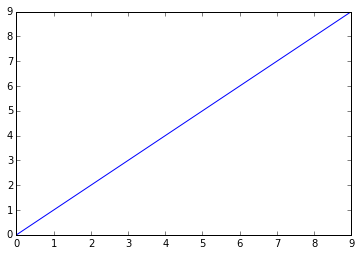

In [2]:
plt.plot(range(10))
fig = plt.gcf()
ax = fig.axes[0]

In [3]:
from ipywidgets import VBox, Text, IntRangeSlider, Dropdown, IntSlider
from IPython.display import display, clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
axis_widget_definitions = [
    {'description': 'x label',
     'widget': Text,
     'property': 'xlabel'
    },
    {'description': 'y label',
     'widget': Text,
     'property': 'ylabel'
    },
    {'description': 'title',
     'widget': Text,
     'property': 'title',
    },
    {'description': 'x limits',
     'widget': IntRangeSlider,
     'kwargs': {
            # Make the starting range the middle third of the available range
            'min': lambda v: v[0] - (v[1] - v[0]),
            'max': lambda v: v[1] + (v[1] - v[0]),
        },
     'property': 'xlim'
    },
    {'description': 'y limits',
     'widget': IntRangeSlider,
     'kwargs': {
            'min': lambda v: v[0] - (v[1] - v[0]),
            'max': lambda v: v[1] + (v[1] - v[0]),
        },
     'property': 'ylim'
    },
]

The implementation is still something of a work in progress.

In [5]:
class TunerBase:
    def __init__(self, obj):
        self.obj = obj
        self.changed_params = {}
        self.child_tuners = {}
    
    _widget = None
    
    @property
    def widget(self):
        if self._widget is None:
            self._widget = self._build_widget()
        return self._widget

    def make_set_callback(self, property_name):
        def value_changed(_, new):
            self.changed_params[property_name] = new
            self.obj.set(**{property_name: new})
            clear_output(wait=True)
            display(self.obj.figure)
        
        return value_changed

    def get_code(self, obj_name='o'):
        lines = []
        for property_name, value in self.changed_params.items():
            lines.append("{}.set_{}({!r})".format(obj_name, property_name, value))
        return lines
    
    def code_to_cell(self, obj_name='o'):
        code = "\n".join(self.get_code(obj_name))
        get_ipython().set_next_input(code)

In [6]:
line_widget_definitions = [
    {'description': 'line width',
     'widget': IntSlider,
     'kwargs': {
            'min': 1,
            'max': 10
        },
     'property': 'linewidth'
    },
]

class LineTuner(TunerBase):
    def _build_widget(self):
        ww = []
        for widget_def in line_widget_definitions:
            property_name = widget_def['property']
            initial_value = plt.get(self.obj, property_name)
            kwargs = {}
            for k, v in widget_def.get('kwargs', {}).items():
                if callable(v):
                    kwargs[k] = v(initial_value)
                else:
                    kwargs[k] = v
            w = widget_def['widget'](value=initial_value,
                                     description=widget_def['description'],
                                     **kwargs)
            w.on_trait_change(self.make_set_callback(property_name), 'value')
            ww.append(w)
        
        print(ww)
        
        return VBox(children=tuple(ww))
        

In [7]:
class AxisTuner(TunerBase):
    
    def _build_widget(self):
        ww = []
        for widget_def in axis_widget_definitions:
            property_name = widget_def['property']
            initial_value = plt.get(self.obj, property_name)
            kwargs = {}
            for k, v in widget_def.get('kwargs', {}).items():
                if callable(v):
                    kwargs[k] = v(initial_value)
                else:
                    kwargs[k] = v
            w = widget_def['widget'](value=initial_value,
                                     description=widget_def['description'],
                                     **kwargs)
            w.on_trait_change(self.make_set_callback(property_name), 'value')
            ww.append(w)
        
        objects_choices = []
        for i, line in enumerate(self.obj.lines):
            print(line)
            plot_obj_id = 'line:%d' % i
            objects_choices.append(('Line %d' % (i+1), plot_obj_id))
            self.child_tuners[plot_obj_id] = LineTuner(line)
        
        if objects_choices:
            object_selector = Dropdown(options=objects_choices)
            ww.append(object_selector)
            first_child_widget = self.child_tuners[objects_choices[0][1]].widget
            object_tuner_box = VBox(children=(first_child_widget,))
            ww.append(object_tuner_box)
            def switch_child(_, new):
                new_widget = self.child_tuners[new].widget
                object_tuner_box.children = (new_widget,)
            object_selector.on_trait_change(switch_child, 'value')
    
        return VBox(children=tuple(ww))
    
    def get_code(self, axis_name='ax'):
        lines = []
        for property_name, value in self.changed_params.items():
            lines.append("{}.set_{}({!r})".format(axis_name, property_name, value))
        for i, line in enumerate(self.obj.lines):
            line_tuner = self.child_tuners['line:%d' % i]
            lines.extend(line_tuner.get_code(axis_name + ".lines[%d]" % i))
        return lines

def tune_axis(ax):
    at = AxisTuner(ax)
    display(at.widget)
    display(ax.figure)
    return at

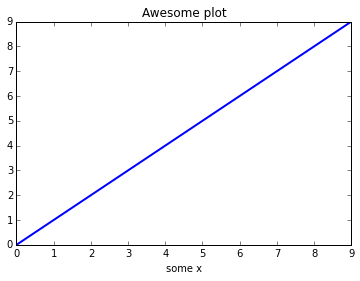

In [8]:
tuner = tune_axis(ax)

## Getting the code

We don't want to have to redo these tweaks by hand every time we generate the plot. So the tuner records the changes we made, and it can generate Python code to reproduce the same settings.

In [9]:
tuner.get_code()

["ax.set_xlabel('some x')",
 "ax.set_title('Awesome plot')",
 'ax.lines[0].set_linewidth(2)']

In [10]:
# This will put the code in the next cell
tuner.code_to_cell()

In [ ]:
o.set_xlabel('some x')
o.set_title('Awesome plot')
o.lines[0].set_linewidth(2)